In [ ]:
#Fakharyar Khan and Colin Hwang
#ECE-475: Frequentist Machine Learning
#Project 1: Linear Regression
#Professor Keene

#importing all of the necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import math


In [ ]:
# extracts the dataset from the csv file
# splits the dataset into the training, testing, and validation set
# takes in the filename of the csv file, the name of the labels,
# and whether or not to use the prostate data

def prepare_data(filename, label, prostate, new_features):

  # if prostate is true, take out the last column 
  # (related to data splitting from the textbook)
  # and uses the first column as indices (the csv file had the indices as a column)

  if(new_features):
    ds = pd.read_csv(filename)
    weight = ds["Water  (component 4)(kg in a m^3 mixture)"] + ds["Blast Furnace Slag (component 2)(kg in a m^3 mixture)"]
    weight += ds["Fly Ash (component 3)(kg in a m^3 mixture)"] + ds["Cement (component 1)(kg in a m^3 mixture)"]
    weight += ds["Superplasticizer (component 5)(kg in a m^3 mixture)"] + ds["Coarse Aggregate  (component 6)(kg in a m^3 mixture)"]
    weight += ds["Fine Aggregate (component 7)(kg in a m^3 mixture)"]
    
    ds["Water Percent Composition"] = ds["Water  (component 4)(kg in a m^3 mixture)"]/weight

    ds["Age_log_scale"] = np.log10(ds["Age (day)"])

  elif(prostate):
    ds = pd.read_csv(filename, index_col = [0])
    ds = ds.iloc[:, :-1]
  else:
    ds = pd.read_csv(filename)



  #normalize the dataset to have 0 mean and a standard deviation of 1
  #this is especially necessary for when we add complexity penalties in ridge and
  #lasso regression
  ds=(ds-ds.mean())/ds.std()

  #split the dataset for 80% training set, 10% test set, and 10% validation set
  train, test = train_test_split(ds, test_size = 0.2)
  
  validation, test = train_test_split(test, test_size = 0.5)

  #separate out the label column from each of the sets

  xtest = train[label]

  xtrain = train.drop(label, axis = 1)

  ytest = test[label]

  ytrain = test.drop(label, axis = 1)

  validation_labels = validation[label]

  validation = validation.drop(label, axis = 1)

  return xtrain, xtest, ytrain, ytest, validation, validation_labels

#xtrain: features of training set, xtest: labels of training set
#ytrain: features of training set, ytest: labels of testing set
#validation: features of validation set, validation_labels = labels of validation set

xtrain, xtest, ytrain, ytest, validation, validation_labels = prepare_data("prostatedata 2.csv", "lpsa", True, False)


In [ ]:
#computes the hat matrix which is used to compute the betas
#takes in the feature matrix, X, and lambda

def hatMat(feat_mat, lamb):

  #transpose the feature matrix
  feat_tran = np.transpose(feat_mat)

  #get number of columns
  size = np.size(feat_mat, 1)

  #multipies X^T by X and adds lambda*I

  hat = np.matmul(feat_tran, feat_mat) + lamb*np.identity(size)

  #inverts it and multiplies it by X^T
  hat = np.matmul(np.linalg.inv(hat), feat_tran)

  return hat

#estimates the testing labels from the testing features
#using the betas computed from hatMat
#returns a 1D array consisting of predictions made by model
def predict(betas, test_feat):
  
  predictions = []

  #convert test features to numpy array
  test_feat_array = test_feat.to_numpy()


  #estimate the label and append it to predictions
  for i in range(len(test_feat_array)):
    
    predictions.append(betas[0] + np.dot(betas[1:], test_feat_array[i]))

    
  return predictions


#computes the mean square error of the model
def error(predictions, test_targets):
  
  target_array = test_targets.to_numpy()

  #takes finds square of difference between corresponding
  #prediction and target value

  N = len(predictions)
  mse = 0
  for i in range(N):
    mse += (predictions[i] - target_array[i])**2

  #divide by number of predictions to get mean
  return mse / N

#driver function
#uses above functions to train model and computes error
#returns mse and betas
def driver(lambd, trainx, testx, test_predictors, test_labels):

  #converts training features to numpy array
  xtrain_mat = trainx.to_numpy()

  #get number of rows in xtrain_mat
  size = np.size(xtrain_mat, 0)

  #insert a column of ones to the beginning of xtrain_mat
  xtrain_mat = np.c_[np.ones(size), xtrain_mat]

  #compute hat_matrix
  hat_matrix = hatMat(xtrain_mat, lambd)

  #get betas
  betas = np.matmul(hat_matrix, testx)

  #compute mse
  mse = error(predict(betas, test_predictors), test_labels)

  return betas, mse

In [ ]:
#computes correlation matrix between features

def get_corr_matrix():

  #get correlation matrix
  corr_matr = xtrain.corr()

  #matrix is symmetric so we have redundant information
  #make it a lower triangular matrix
  corr_matr[:] = np.tril(corr_matr.values, k = -1)

  return corr_matr

#compute approximate variance of weights
#takes in the list of targets predicted by the model on the training set,
#number of data points and number of features in model

def weight_variance(predictions, N, p):

  variance = 0

  #convert training feature set to numpy array
  test_label_array = xtest.to_numpy()

  #computes sum of square differences between predicted and 
  #labels

  for i in range(len(predictions)):
    variance += (predictions[i] - test_label_array[i])**2
  
  return variance/(N-p - 1)


#gets zscore and standard error of a feature
#beta is the coefficient of the feature found by the model
#feat_mat is training feature set 
#index denotes the feature number and stddev is the standard deviation of the feature

def get_zscore_stderror(beta, feat_mat, index, stddev):

  #computes (X^T)*X
  A = np.matmul(np.transpose(feat_mat), feat_mat)

  #inverts it
  A = np.linalg.inv(A)

  #get the jth diagonal entry in the matrix
  vj = A[index][index]

  #computes standard error
  stderror = stddev*(vj**0.5)
  #computes zscore
  zscore = beta/stderror

  return zscore, stderror



In [ ]:
#creates a nice ordered output of the model statistics
#takes in betas, the feature matrix, and predictions made by model on testing set
#replicates Tables 3.1 and 3.2

def generate_tables(betas, feat_mat, predictions):

  #prints correlation matrix (table 3.1)
  print("------------------------Correlation of Predictors------------------------\n")
  print(get_corr_matrix())
  print("\n\n\n")

  #get standard deviation
  stddev = weight_variance(predictions, len(feat_mat), feat_mat.shape[1])**0.5


  zscores= []

  stderrors = []

  #compute zscores and stderrors for each feature
  for i in range(len(betas)):
    scores = get_zscore_stderror(betas[i], feat_mat, i, stddev)

    zscores.append(scores[0])
    stderrors.append(scores[1])
  

  #make dataframe showing statistical information
  #Term is the name of the feature
  #Coefficient is the corresponding weight
  #and Std. error and z score are the corresponding values for the features

  headers = ["Term", "Coefficient", "Std. Error", "Z Score"]

  
  null_hyp_stats = pd.DataFrame(columns = headers)

  #add in intercept term
  null_hyp_stats["Term"] = ["Intercept"] + list(xtrain.columns.values)

  null_hyp_stats["Coefficient"] = betas

  null_hyp_stats["Std. Error"] = stderrors

  null_hyp_stats["Z Score"] = zscores

  #print out the statistics table (table 3.2)
  print("------------------------Null Hypothesis Statistics------------------------\n")
  print(null_hyp_stats)
  print("\n\n\n")

In [ ]:
#displays results of the linear regression model
#takes in lambda
def main(lambd):

  #compute testing and training error

  #convert training set to numpy array
  xtrain_mat = xtrain.to_numpy()

  size = np.size(xtrain_mat, 0)
  #add a column of 1s to beginning of xtrain_mat
  xtrain_mat = np.c_[np.ones(size), xtrain_mat]

  #get hat matrix and betas
  hat_matrix = hatMat(xtrain_mat, lambd)

  betas = np.matmul(hat_matrix, xtest)


  #compute testing and training errors
  testing_error = error(predict(betas, ytrain), ytest)

  training_error = error(predict(betas, xtrain), xtest)

  #get predictions for training set from model
  train_predictions = predict(betas, xtrain)

  #generate the statistics tables
  generate_tables(betas, xtrain_mat, train_predictions)

  print("------------------------Model Performance------------------------\n")
  print("Mean Square Error on Training Set: ", training_error)
  print("Mean Square Error on Testing Set: ", testing_error)


main(0)
  


------------------------Correlation of Predictors------------------------

           lcavol   lweight       age      lbph       svi       lcp   gleason  \
lcavol   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
lweight  0.276993  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
age      0.250337  0.330566  0.000000  0.000000  0.000000  0.000000  0.000000   
lbph     0.019072  0.422805  0.304011  0.000000  0.000000  0.000000  0.000000   
svi      0.501572  0.132849  0.100634 -0.091507  0.000000  0.000000  0.000000   
lcp      0.654905  0.163969  0.176918 -0.032577  0.652233  0.000000  0.000000   
gleason  0.407443  0.011657  0.291772  0.073802  0.321277  0.520282  0.000000   
pgg45    0.424086  0.078459  0.263130  0.060522  0.454978  0.647575  0.769758   

         pgg45  
lcavol     0.0  
lweight    0.0  
age        0.0  
lbph       0.0  
svi        0.0  
lcp        0.0  
gleason    0.0  
pgg45      0.0  




------------------------Null Hypothesi

In [ ]:
#chooses the lambda that provides the lowest MSE score on the validation set
#outputs the optimal lambda, optimal weights, and a list of coefficients used 
#for each value of lambda (for graphing use later)

def ridge_best_lambda(trainx, testx, trainy, testy, val, val_labels,):
  opt_lamb = 0

  mini_error = float('inf')

  coeff = []

  opt_betas = []

  #have lambda run through values from 0.01 to 10 in increments of 0.01
  for lamb in np.arange(0.01, 10, 0.01):

    #get betas and error observed on validation set using driver function
    betas, observed_error = driver(lamb, trainx, testx, val, val_labels)

    #add the list of weights to coeff
    coeff.append(betas)

    #if we found a smaller error, it becomes new mini_error
    #and reset opt_betas and opt_lambda
    if observed_error < mini_error:
      mini_error = observed_error
      opt_betas = betas
      opt_lamb = lamb

      
  #get testing and training error
  testing_error = error(predict(opt_betas, trainy), testy)

  training_error = error(predict(opt_betas, trainx), testx)

  #display results
  print("------------------------Optimal Value of Lambda------------------------\n")

  print(f"Optimal Value for Lambda Found is: {opt_lamb} yeilding a MSE on the test dataset of: {testing_error}")
  print(f"Optimal Value for Lambda Found is: {opt_lamb} yeilding a MSE on the training dataset of: {training_error}")

  print("\n\n\n")

  return opt_lamb, opt_betas, coeff

#finds best lambda for lasso model (based on performance on validation set)
#outputs the optimal lambda, optimal weights, and a list of coefficients used 
#for each value of lambda (for graphing use later)

def lasso_best_lambda(trainx, testx, trainy, testy, val_feat, val_lab):
  coeff = []
  min_error = float('inf')

  betas = []
  opt_lamb = 0

  #have lambda run through values from 0.01 to 1 in increments of 0.01
  for lambd in np.arange(0.01,1, 0.01):

    #set model parameters (just the lambda)
    model = Lasso(alpha = lambd)

    #fit the model on the training set
    model.fit(trainx, testx)

    #get model weights
    coeff.append(model.coef_)

    #get mean squared error
    mse = mean_squared_error(model.predict(val_feat), val_lab)

    # if error less than min_error update betas and opt_lambd
    if mse < min_error:
      min_error = mse
      betas = model.coef_
      opt_lamb = lambd

  #get mean squared error for training and testing sets

  model = Lasso(alpha = opt_lamb)
  model.fit(trainx, testx)
  testing_error = mean_squared_error(model.predict(trainy), testy)
  training_error = mean_squared_error(model.predict(trainx), testx)

  #display results
  print("------------------------Optimal Value of Lambda------------------------\n")

  
  print(f"Optimal Value for Lambda Found is: {opt_lamb} yeilding a MSE of {testing_error} on the test dataset")
  print(f"Optimal Value for Lambda Found is: {opt_lamb} yeilding a MSE of {training_error} on the training dataset")

  print("\n\n\n")
  return opt_lamb, betas, coeff




  






------------------------Plot of Ridge Model Coefficients Against Lambda------------------------

------------------------Optimal Value of Lambda------------------------

Optimal Value for Lambda Found is: 9.99 yeilding a MSE on the test dataset of: 0.41495026600973717
Optimal Value for Lambda Found is: 9.99 yeilding a MSE on the training dataset of: 0.34017493107558916






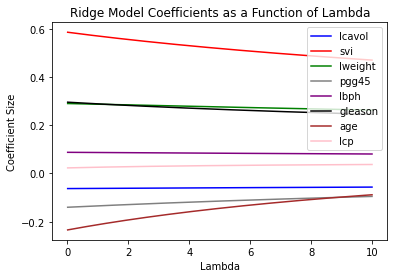





------------------------Plot of Lasso Model Coefficients Against Lambda------------------------

------------------------Optimal Value of Lambda------------------------

Optimal Value for Lambda Found is: 0.19 yeilding a MSE of 0.5525701605609996 on the test dataset
Optimal Value for Lambda Found is: 0.19 yeilding a MSE of 0.43835071519538343 on the training dataset






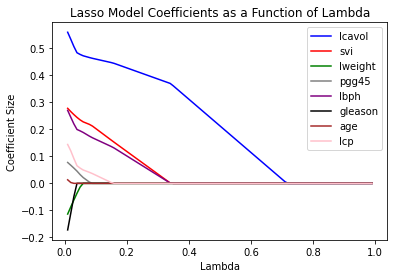

In [ ]:
#plots feature coefficients as a function of lambda

def coefficients_plot(ridge):
  # if ridge get the coefficients from the ridge model
  if(ridge):
    opt_lamb, betas, coeff = ridge_best_lambda(xtrain, xtest, ytrain, ytest, validation, validation_labels)
    max_lamb = 10

  #else get it from the lasso model
  else:
    opt_lamb, betas, coeff = lasso_best_lambda(xtrain, xtest, ytrain, ytest, validation, validation_labels)
    max_lamb = 1

  
  lcavol = []
  svi = []
  lweight = []
  pgg45 = []
  lbph = []
  gleason = []
  age = []

  lcp = []

  #add weights to their corresponding feature array
  for weights in coeff:

    lcavol.append(weights[0])
    svi.append(weights[1])
    lweight.append(weights[2])

    pgg45.append(weights[3])
    lbph.append(weights[4])
    gleason.append(weights[5])
    age.append(weights[6])
    lcp.append(weights[7])
  
  #plot the coefficients against lambdas
  lambdas = np.arange(0.01, max_lamb, 0.01)

  plt.plot(lambdas, lcavol, color = 'blue', label = 'lcavol')
  plt.plot(lambdas, svi, color = 'red', label = 'svi')
  plt.plot(lambdas, lweight, color = 'green', label = 'lweight')
  plt.plot(lambdas, pgg45, color = 'grey', label = 'pgg45')
  plt.plot(lambdas, lbph, color = 'purple', label = 'lbph')
  plt.plot(lambdas, gleason, color = 'black', label = 'gleason')
  plt.plot(lambdas, age, color = 'brown', label = 'age')
  plt.plot(lambdas, lcp, color = 'pink', label = 'lcp')

  if(ridge):
    plt.title("Ridge Model Coefficients as a Function of Lambda")
  else:
    plt.title("Lasso Model Coefficients as a Function of Lambda")
    
  plt.xlabel("Lambda")
  plt.ylabel("Coefficient Size")
  

  plt.legend(loc="upper right")

  plt.show()

print("------------------------Plot of Ridge Model Coefficients Against Lambda------------------------\n")

coefficients_plot(True)

print("\n\n\n")

print("------------------------Plot of Lasso Model Coefficients Against Lambda------------------------\n")

coefficients_plot(False)





------------------------Mean Squared Error of Linear Regression Model on Concrete Data------------------------



Mean Square Error on Testing Set:   0.1626463394604134
Mean Square Error on Training Set:   0.16170518281499194





------------------------Mean Squared Error of Ridge Regression Model on Concrete Data-------------------------




------------------------Optimal Value of Lambda------------------------

Optimal Value for Lambda Found is: 0.15000000000000002 yeilding a MSE on the test dataset of: 0.17088276874930158
Optimal Value for Lambda Found is: 0.15000000000000002 yeilding a MSE on the training dataset of: 0.16240155417237698








------------------------Optimal Value of Lambda------------------------

Optimal Value for Lambda Found is: 0.01 yeilding a MSE of 0.2034034551103739 on the test dataset
Optimal Value for Lambda Found is: 0.01 yeilding a MSE of 0.17200118224688316 on the training dataset




------------------------Plot of Lasso Model Coefficients Agai

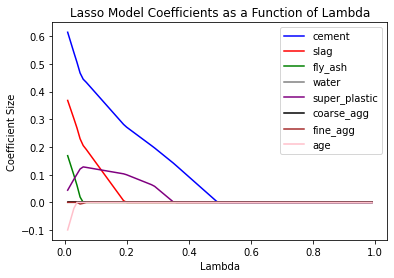

In [ ]:
#For this part, we picked a dataset on concrete strength
#and trained our three models on this dataset

#extract and split the data
enxtrain, enxtest, enytrain, enytest, envalidation, envalidation_labels = prepare_data("Concrete.csv", "Concrete", False, True)

#train the linear model and test it out on the training and testing sets
beta, testing_error = driver(0, enxtrain, enxtest, enytrain, enytest)

beta, training_error = driver(0, enxtrain, enxtest, enxtrain, enxtest)

#display results for linear model

print("\n\n\n")
print("------------------------Mean Squared Error of Linear Regression Model on Concrete Data------------------------\n")

print("\n")
print("Mean Square Error on Testing Set:  ", testing_error)
print("Mean Square Error on Training Set:  ", training_error)

#train and find the optimal lambda for the ridge model
#using the ridge_best_lambda function and print out results

print("")
print("\n\n\n")
print("------------------------Mean Squared Error of Ridge Regression Model on Concrete Data-------------------------\n")

print("\n\n")
ridge_best_lambda(enxtrain, enxtest, enytrain, enytest, envalidation, envalidation_labels)

print("\n\n\n")

#this function is very similar to coefficients_plot
#but for the concrete dataset
#it plots the coefficients of the lasso model against lambda

def coef_energy_plot(new_features):
  #get best lambda, best set of coefficients, and list of weights
  opt_lamb, betas, coeff = lasso_best_lambda(enxtrain, enxtest, enytrain, enytest, envalidation, envalidation_labels)

  cement = []
  slag = []
  fly_ash = []
  water = []
  super_plastic = []
  coarse_agg = []
  fine_agg = []
  age = []

  water_percent = []
  age_log = []
  
  #add weights to their corresponding feature array
  for weights in coeff:
    cement.append(weights[0])
    slag.append(weights[1])
    fly_ash.append(weights[2])
    water.append(weights[3])
    super_plastic.append(weights[4])
    coarse_agg.append(weights[5])
    fine_agg.append(weights[6])
    age.append(weights[7])

    if(new_features):
      water_percent.append(weights[8])
      age_log.append(weights[9])


  #plot the weights as a function of lambda
  lambdas = np.arange(0.01, 1, 0.01)

  plt.plot(lambdas, cement, color = 'blue', label = 'cement')
  plt.plot(lambdas, slag, color = 'red', label = 'slag')
  plt.plot(lambdas, fly_ash, color = 'green', label = 'fly_ash')
  plt.plot(lambdas, water, color = 'grey', label = 'water')
  plt.plot(lambdas, super_plastic, color = 'purple', label = 'super_plastic')
  plt.plot(lambdas, coarse_agg, color = 'black', label = 'coarse_agg')
  plt.plot(lambdas, fine_agg, color = 'brown', label = 'fine_agg')
  plt.plot(lambdas, age, color = 'pink', label = 'age')

  if(new_features):
    plt.plot(lambdas, fine_agg, color = 'orange', label = 'Water  (component 4)(kg in a m^3 mixture)')
    plt.plot(lambdas, age, color = 'cyan', label = 'Age_log_scale')


  plt.title("Lasso Model Coefficients as a Function of Lambda")
  plt.xlabel("Lambda")
  plt.ylabel("Coefficient Size")
  plt.legend(loc="upper right")

  print("------------------------Plot of Lasso Model Coefficients Against Lambda-------------------------\n")
  
  plt.show()





coef_energy_plot(False)






------------------------Mean Squared Error of Linear Regression Model on Concrete Data------------------------



Mean Square Error on Testing Set:   0.164520679853958
Mean Square Error on Training Set:   0.1689305257492854





------------------------Mean Squared Error of Ridge Regression Model on Concrete Data-------------------------




------------------------Optimal Value of Lambda------------------------

Optimal Value for Lambda Found is: 0.01 yeilding a MSE on the test dataset of: 0.1644149054435435
Optimal Value for Lambda Found is: 0.01 yeilding a MSE on the training dataset of: 0.16893787836878227








------------------------Optimal Value of Lambda------------------------

Optimal Value for Lambda Found is: 0.01 yeilding a MSE of 0.17329083373359705 on the test dataset
Optimal Value for Lambda Found is: 0.01 yeilding a MSE of 0.18160017482388294 on the training dataset




------------------------Plot of Lasso Model Coefficients Against Lambda----------------------

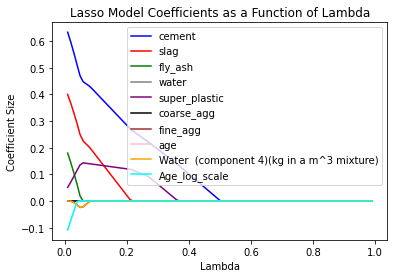

In [ ]:
#Here we will generate new features

#Water composition: is defined as the composition of water in the cement as a fraction of the weight of the cement 
#found by dividing the water weight by the weights of all of the components of cement that we have. The idea
#is that if a cement block has a lot of water in it, it's gonna be soft and squishy and not very strong
#but if it has almost no water, it will be hard and tough (not a cive so this prbly isn't right)

#Age_log: defined as log of age of concrete
#we chose this feature because there's a huge difference between fresh new concrete and concrete that's 5 years old 
#but not that much difference between a 130 year old concrete and a 135 year old concrete
#so the strength is kinda like a log (although it should be a decreasing function which might explain the results we got, e^-x would have been better maybe)

#Unfortunately there wasn't a significant change in ther results. The mean square errors were roughly the same as before we used the new features
#and the lasso model immediately rejected the water composition feature (the age_log feature stayed for a bit but also eventually died out)
#The water composition feature not working might be a result of us just being wrong about how cement works
#but for the age_log I think we had the right idea but we used the wrong function. The cement strength decreases with age
#but the log function is an increasing so it couldn't really accurately describe the relationship between age and strenght
#instead we believe that the cement strength is more closely related to e^-{Age} as e^-x is decreasing and gets "slower"
#since its derivative goes to 0

#prepare the dataset with the new features
enxtrain, enxtest, enytrain, enytest, envalidation, envalidation_labels = prepare_data("Concrete.csv", "Concrete", False, True)

#and everything else is essentially the same as the code block before

beta, testing_error = driver(0, enxtrain, enxtest, enytrain, enytest)

beta, training_error = driver(0, enxtrain, enxtest, enxtrain, enxtest)

#display results for linear model

print("\n\n\n")
print("------------------------Mean Squared Error of Linear Regression Model on Concrete Data------------------------\n")

print("\n")
print("Mean Square Error on Testing Set:  ", testing_error)
print("Mean Square Error on Training Set:  ", training_error)


#train and find the optimal lambda for the ridge model
#using the ridge_best_lambda function and print out results

print("")
print("\n\n\n")
print("------------------------Mean Squared Error of Ridge Regression Model on Concrete Data-------------------------\n")

print("\n\n")
ridge_best_lambda(enxtrain, enxtest, enytrain, enytest, envalidation, envalidation_labels)

print("\n\n\n")

coef_energy_plot(True)


SUMMARY

- **Which features did the Lasso select for you to include in your model?**

  For the prostate dataset, the Lasso:
  - selected lcavol, lweight, lbph, svi, lcp, gleason, pgg45 to be included
  - excluded age

  For the concrete dataset, the Lasso:
  - selected cement, slag, fly_ash, water, super_plastic, and age to be included
  - excluded course_agg and fine_agg

  We would also like to mention that based off our plot of the Lasso results, lcp, gleason, and pgg45 had coefficent values close to zero, and were almost not included by the Lasso. This is similar to the results obtained by the textbook's analysis of the prostate dataset where age, lcp, gleason, and pgg45 were all excluded. 


- **Do these features make sense?**

  We are unsure whether or not age being excluded makes sense. A quick google search gives an overwhelming response indicating that the liklihood of prostate cancer increases with age. However, an study (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5385861/) done on whether age is an independent factor for prostate cancer tells us that age does not appear to be an independent predictor for prostate cancer incidence. This means that combining age with another feature to create an interaction term may make improve results and make age a worthwile feature to include in our model.

  We are also unsure whether or not excluding course aggregate and fine aggreagate makes sense as we are not knowledgable about what should/should not affect the compressive strength of concrete. However, the Lasso does tell us that it is likely that the type of aggregate has no effect on concrete's compressive strength.



- **Compute the MSE on the training dataset and the test dataset for all methods and comment on the results**. 

  Below are the results we obtained on the performance of the 3 models we created on 2 datasets:

  - Prostate Cancer Dataset
    - Linear
      - Training: 0.34
      - Testing: 0.44
    -  Ridge
      - Training: 0.34
      - Testing: 0.45
    -   Lasso
      - Training: 0.34
      - Testing: 0.44
  
  -  Concrete Dataset
    - Linear
      - Training: 0.16
      - Testing: 0.17
    - Ridge
      - Training: 0.16
      - Testing: 0.17
    - Lasso
      - Training: 0.18
      - Testing: 0.18

  As expected, on the prostate cancer dataset the mean square error on the training set is significantly lower than that on the testing set. This makes sense since the error on the training set is a big part of the models' cost functions. 

  On the concrete dataset, the mean square error of the training set for every model is almost identical to the error of the testing set. It might be that our training data was very representative of the testing data so the errors ended up being very close to one another. The mean square error on the concrete dataset is also much lower than the error found in the prostate cancer dataset.

  One possible explanation for the difference in performances between the two datasets might be that the factors that contribute to concrete strength are already well known whereas the ones that cause prostate cancer could still be up for debate. Additionally, I think some of the features given in the prostate dataset correlate strongly with having prostate cancer but don't actually cause it which might make it a harder task for a model to predict prostate cancer using those features. On the other hand, the features on the concrete dataset seem to directly affect concrete strength and so there might be some really complex formula that determines concrete strength from these features that the model can try to approximate. 


- **Compare this MSE to a baseline MSE.**

  In Elements of Statistical Learning, the baseline MSE for the three models were:

  - Linear: 0.521
  - Ridge: 0.492
  - Lasso: 0.479

  The performance of our models are comparable to that of the models made in the textbook. The variations between the corresponding models are likely due to a difference in sampling for the training, validation, and testing sets.

